In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, accuracy_score, precision_score, recall_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

LOAD PREPROCESSED DATA

In [3]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")


Training samples: 227845
Test samples: 56962
Number of features: 30


RESHAPE DATA FOR CNN-1D

In [4]:
# CNN-1D expects 3D input: (samples, sequence_length, channels)
# Each feature is treated as a point in the sequence
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\nReshaped training data: {X_train_cnn.shape}")
print(f"Reshaped test data: {X_test_cnn.shape}")
print(f"Format: (samples, sequence_length, channels)")


Reshaped training data: (227845, 30, 1)
Reshaped test data: (56962, 30, 1)
Format: (samples, sequence_length, channels)


BUILD CNN-1D MODEL

In [5]:
def create_cnn1d_model(input_shape):
    """
    Creates a 1D CNN model with:
    - Multiple Conv1D layers for feature extraction
    - MaxPooling for dimensionality reduction
    - Dense layers for classification
    - Dropout and BatchNorm for regularization
    """
    model = Sequential([
        # First Convolutional Block
        Conv1D(filters=64, kernel_size=3, activation='relu', 
               input_shape=input_shape, name='conv1d_1'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Second Convolutional Block
        Conv1D(filters=128, kernel_size=3, activation='relu', name='conv1d_2'),
        BatchNormalization(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        
        # Third Convolutional Block
        Conv1D(filters=64, kernel_size=3, activation='relu', name='conv1d_3'),
        BatchNormalization(),
        Dropout(0.2),
        
        # Flatten for dense layers
        Flatten(),
        
        # Dense layers
        Dense(128, activation='relu', name='dense_1'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu', name='dense_2'),
        Dropout(0.2),
        
        Dense(32, activation='relu', name='dense_3'),
        
        # Output layer
        Dense(1, activation='sigmoid', name='output_layer')
    ])
    
    return model

In [6]:
# Create model
input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])
model = create_cnn1d_model(input_shape)

In [7]:
# Display model architecture
print("\nCNN-1D Model Architecture:")
model.summary()


CNN-1D Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 28, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 28, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 12, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 12, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 4, 64)               │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 94,401 (368.75 KB)

 Trainable params: 93,633 (365.75 KB)

 Non-trainable params: 768 (3.00 KB)

COMPILE MODEL

In [8]:
# Calculate class weights
neg_count = len(y_train) - y_train.sum()
pos_count = y_train.sum()
total = len(y_train)

weight_for_0 = (1 / neg_count) * (total / 2.0)
weight_for_1 = (1 / pos_count) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"\nClass weights:")
print(f"Normal transactions (0): {weight_for_0:.4f}")
print(f"Fraud transactions (1): {weight_for_1:.4f}")



Class weights:
Normal transactions (0): 0.5009
Fraud transactions (1): 289.1434


In [9]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

SETUP CALLBACKS

In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'cnn1d_best_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

TRAIN MODEL

In [11]:
history = model.fit(
    X_train_cnn, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8486 - auc: 0.9107 - loss: 0.4098 - precision: 0.0120 - recall: 0.8282
Epoch 1: val_auc improved from None to 0.97223, saving model to cnn1d_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 43s 43ms/step - accuracy: 0.9090 - auc: 0.9309 - loss: 0.3384 - precision: 0.0157 - recall: 0.8457 - val_accuracy: 0.9726 - val_auc: 0.9722 - val_loss: 0.1530 - val_precision: 0.0557 - val_recall: 0.8795 - learning_rate: 0.0010
Epoch 2/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9397 - auc: 0.9718 - loss: 0.2073 - precision: 0.0271 - recall: 0.9313
Epoch 2: val_auc improved from 0.97223 to 0.97899, saving model to cnn1d_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 27s 38ms/step - accuracy: 0.9458 - auc: 0.9632 - loss: 0.2443 - precision: 0.0275 - recall: 0.8939 - val_accuracy: 0.9371 - val_auc: 0.9790 - val_loss: 0.2017 - val_precision: 0.0259 - val_recall: 0.9157 - learning_rate: 0.0010
Epoch 3/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9369 - auc: 0.9730 - loss: 0.1890 - precision: 0.0266 - recall: 0.9380
Epoch 3: val_auc improved from 0.97899 to 0.98256, saving model to cnn1d_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.9477 - auc: 0.9632 - loss: 0.2201 - precision: 0.0287 - recall: 0.9035 - val_accuracy: 0.9479 - val_auc: 0.9826 - val_loss: 0.1726 - val_precision: 0.0308 - val_recall: 0.9036 - learning_rate: 0.0010
Epoch 4/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.9455 - auc: 0.9842 - loss: 0.1481 - precision: 0.0303 - recall: 0.9463
Epoch 4: val_auc did not improve from 0.98256
713/713 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - accuracy: 0.9492 - auc: 0.9787 - loss: 0.1750 - precision: 0.0298 - recall: 0.9132 - val_accuracy: 0.9475 - val_auc: 0.9814 - val_loss: 0.1544 - val_precision: 0.0305 - val_recall: 0.9036 - learning_rate: 0.0010
Epoch 5/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9442 - auc: 0.9825 - loss: 0.1508 - precision: 0.0294 - recall: 0.9342
Epoch 5: val_auc improved from 0.98256 to 0.98323, saving model to cnn1d_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 38s 53ms/step - accuracy: 0.9476 - auc: 0.9767 - loss: 0.1835 - precision: 0.0286 - recall: 0.9003 - val_accuracy: 0.9590 - val_auc: 0.9832 - val_loss: 0.1558 - val_precision: 0.0373 - val_recall: 0.8675 - learning_rate: 0.0010
Epoch 6/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9507 - auc: 0.9866 - loss: 0.1366 - precision: 0.0332 - recall: 0.9427
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_auc improved from 0.98323 to 0.98332, saving model to cnn1d_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.9519 - auc: 0.9798 - loss: 0.1735 - precision: 0.0314 - recall: 0.9100 - val_accuracy: 0.9327 - val_auc: 0.9833 - val_loss: 0.2025 - val_precision: 0.0245 - val_recall: 0.9277 - learning_rate: 0.0010
Epoch 7/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9452 - auc: 0.9874 - loss: 0.1325 - precision: 0.0306 - recall: 0.9562
Epoch 7: val_auc improved from 0.98332 to 0.98897, saving model to cnn1d_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - accuracy: 0.9545 - auc: 0.9835 - loss: 0.1549 - precision: 0.0335 - recall: 0.9196 - val_accuracy: 0.9640 - val_auc: 0.9890 - val_loss: 0.1138 - val_precision: 0.0439 - val_recall: 0.9036 - learning_rate: 5.0000e-04
Epoch 8/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9567 - auc: 0.9882 - loss: 0.1204 - precision: 0.0376 - recall: 0.9521
Epoch 8: val_auc did not improve from 0.98897
713/713 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.9596 - auc: 0.9861 - loss: 0.1423 - precision: 0.0373 - recall: 0.9132 - val_accuracy: 0.9608 - val_auc: 0.9848 - val_loss: 0.1076 - val_precision: 0.0405 - val_recall: 0.9036 - learning_rate: 5.0000e-04
Epoch 9/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9522 - auc: 0.9916 - loss: 0.1029 - precision: 0.0346 - recall: 0.9573
Epoch 9: val_auc did not improve from 0.98897
713/713 ━━━━━━━━━━━━━━━━━━━━ 36s 51ms/step - accuracy: 0.9569 - auc: 0.9918 - loss: 0.1156 - precision: 0.0356

PLOT TRAINING HISTORY

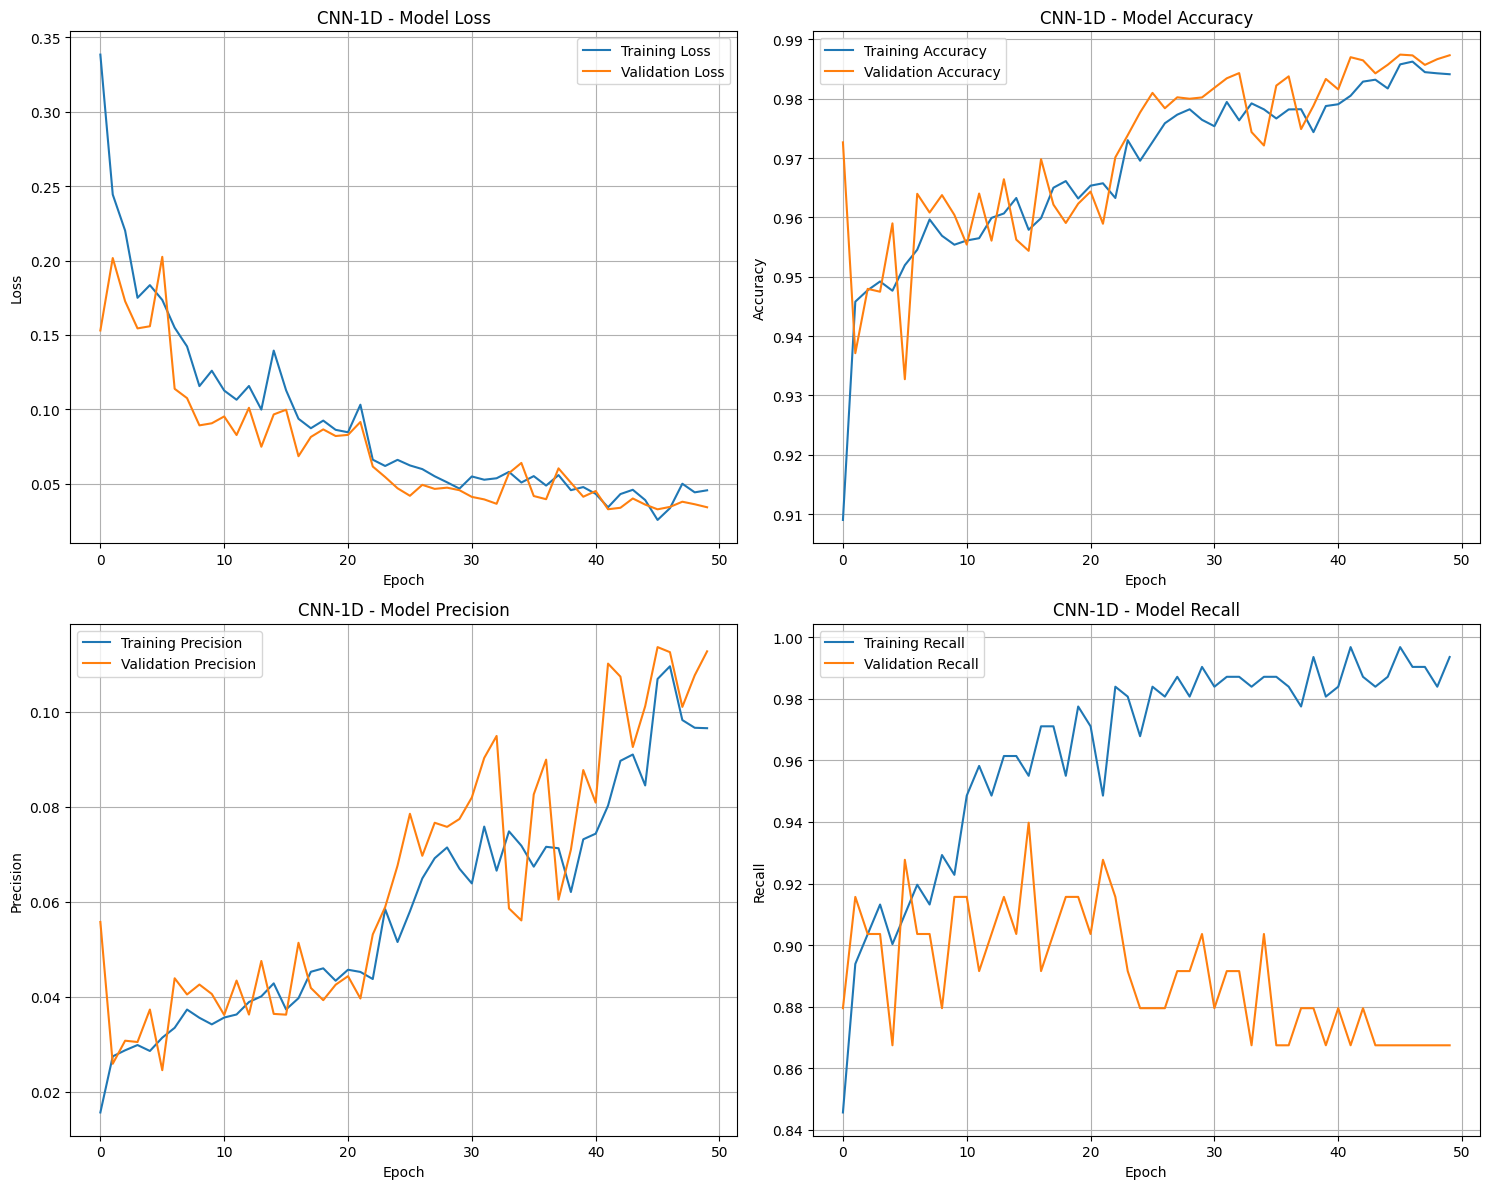

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('CNN-1D - Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('CNN-1D - Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('CNN-1D - Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('CNN-1D - Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('cnn1d_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

EVALUATE MODEL

In [13]:
# Predictions
y_pred_prob = model.predict(X_test_cnn, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nTest Set Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")


Test Set Performance:
Accuracy:  0.9867
Precision: 0.1066
Recall:    0.9082
F1-Score:  0.1908
ROC-AUC:   0.9628
